In [29]:
# Data Manipulation
import numpy as np 
import pandas as pd


# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle
import warnings
warnings.filterwarnings("ignore")
# Set the options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 120})

In [30]:
df = pd.read_csv('timeSeries.csv', parse_dates= ['date'])

In [31]:
df.dropna(axis=1, thresh= len(df)*0.8, inplace= True)
print(len(df))
df.isna().sum()

2379893


Unnamed: 0                   0
testPositivityRatio     368114
caseDensity_x            45455
infectionRate           163354
infectionRateCI90       163354
date                         0
fips                         0
country                      0
state                        0
county                       0
level                        0
locationId                   0
population                   0
cases                    63072
deaths                  114534
newCases                 84886
newDeaths               124434
overall                      0
caseDensity_y                0
cdcTransmissionLevel         0
dtype: int64

In [32]:
df['newDeathRatio'] = df['newDeaths']/df['population']
df['newCasesRatio'] = df['newCases']/df['population']
df['deathsRatio'] = df['deaths']/df['population']
df['casesRatio'] = df['cases']/df['population']

In [33]:
merged1 = df[['date', 'state', 'county', 'population', 'newDeaths', 'newCases', 'newCasesRatio', 'newDeathRatio']]
mandate_df = pd.read_csv('regulations1.csv', parse_dates= ['date'])
mandate_df.columns

Index(['Unnamed: 0', 'State_Tribe_Territory', 'County_Name', 'FIPS_State',
       'FIPS_County', 'date', 'Order_code',
       'Stay_at_Home_Order_Recommendation', 'Action', 'restaurant_order',
       'General_GB_order_group', 'General_GB_order_code', 'mask_order'],
      dtype='object')

In [34]:
merged1 = merged1.merge(mandate_df, left_on= [ 'state', 'county','date'], right_on=['State_Tribe_Territory', 'County_Name', 'date'], how= 'outer')

In [35]:
merged1.drop(['Unnamed: 0', 'State_Tribe_Territory', 'County_Name', 'FIPS_State', 'FIPS_County'], axis= 1, inplace=True)

In [36]:
merged1 =  pd.get_dummies(merged1, columns=  ['Stay_at_Home_Order_Recommendation', 'Action', 'restaurant_order',
       'General_GB_order_group'],drop_first = True, )

In [37]:
merged1['population'].max()

10039107.0

In [38]:
LAC = merged1[merged1['population']==merged1['population'].max()]

In [39]:
trainc = LAC[LAC['date'] <= '11/01/2021']
trainc = LAC[LAC['date'].isna() == False]
trainc = trainc.set_index('date')
testc = LAC[LAC['date'] > '11/01/2021']
testc = testc.set_index('date')

In [40]:
trainc.isna().sum()

state                                                                                                              0
county                                                                                                             0
population                                                                                                         0
newDeaths                                                                                                         30
newCases                                                                                                          36
newCasesRatio                                                                                                     36
newDeathRatio                                                                                                     30
Order_code                                                                                                       316
General_GB_order_code                                           

In [41]:
columns= [ 'Stay_at_Home_Order_Recommendation_Mandatory for all individuals',
       'Stay_at_Home_Order_Recommendation_Mandatory only for all individuals in certain areas of the jurisdiction',
       'Stay_at_Home_Order_Recommendation_Mandatory only for at-risk individuals in certain areas of the jurisdiction',
       'Stay_at_Home_Order_Recommendation_Mandatory only for at-risk individuals in the jurisdiction',
       'Stay_at_Home_Order_Recommendation_No order for individuals to stay home',
       'Action_Curbside/carryout/delivery only', 'Action_No order found',
       'Action_Open with social distancing/reduced seating/enhanced sanitation',
       'General_GB_order_group_Ban of gatherings over 101 or more people',
       'General_GB_order_group_Ban of gatherings over 11-25 people',
       'General_GB_order_group_Ban of gatherings over 26-50 people',
       'General_GB_order_group_Ban of gatherings over 51-100 people',
       'General_GB_order_group_Bans gatherings of any size',
       'General_GB_order_group_No order found']

In [42]:
trainc.index = pd.DatetimeIndex(trainc.index).to_period('D')

In [43]:
target = 'newCasesRatio'
mod = SARIMAX(trainc[target],
            order= (0,0,1),
             freq= 'D',
             exog = trainc[columns])

result = mod.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:          newCasesRatio   No. Observations:                  809
Model:               SARIMAX(0, 0, 1)   Log Likelihood                4684.668
Date:                Sun, 10 Apr 2022   AIC                          -9337.335
Time:                        00:03:50   BIC                          -9262.202
Sample:                    01-05-2020   HQIC                         -9308.488
                         - 03-23-2022                                         
Covariance Type:                  opg                                         
                                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Stay_at_Home

In [44]:
predictions = pd.Series(result.predict(len(testc), exogenous = columns))

trainc.index = trainc.index.astype('datetime64[ns]')
testc.index = testc.index.astype('datetime64[ns]')
predictions.index = predictions.index.astype('datetime64[ns]')

testc['prediction'] = predictions

Text(0.5, 1.0, 'CA Los Angeles County')

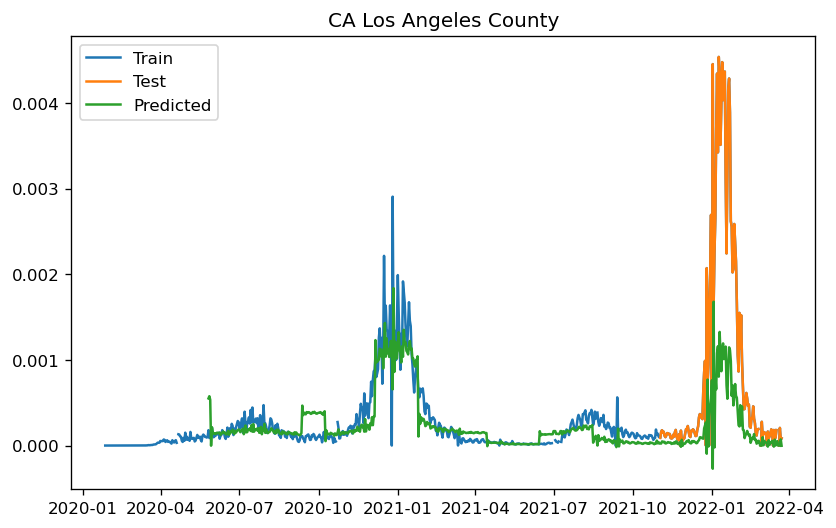

In [45]:
plt.figure(figsize= (8,5))
plt.plot(trainc[target], label= 'Train')
plt.plot(testc[target], label= 'Test')
plt.plot(predictions, label= 'Predicted')
plt.legend(loc= 'upper left')
plt.title(trainc.iloc[1]['state']+ ' ' + trainc.iloc[1]['county'])

In [20]:
from sklearn.metrics import r2_score
r2_score(testc[target].dropna(), testc[testc[target].isna() == False]['prediction'])

0.10302827754432464

In [21]:
target = 'newCasesRatio'
mod = SARIMAX(trainc[target],
            order= (0,0,1),
             freq= 'D')

result = mod.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:          newCasesRatio   No. Observations:                  809
Model:               SARIMAX(0, 0, 1)   Log Likelihood                4612.741
Date:                Thu, 07 Apr 2022   AIC                          -9221.483
Time:                        12:30:22   BIC                          -9212.091
Sample:                    01-05-2020   HQIC                         -9217.877
                         - 03-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3323      0.016     20.418      0.000       0.300       0.364
sigma2      3.834e-07   8.25e-09     46.475      0.000    3.67e-07       4e-07
Ljung-Box (L1) (Q):                 452.66   Jarque-

In [22]:
predictions = pd.Series(result.predict(len(testc), exogenous = columns))

trainc.index = trainc.index.astype('datetime64[ns]')
testc.index = testc.index.astype('datetime64[ns]')
predictions.index = predictions.index.astype('datetime64[ns]')

testc['prediction'] = predictions

Text(0.5, 1.0, 'CA Los Angeles County')

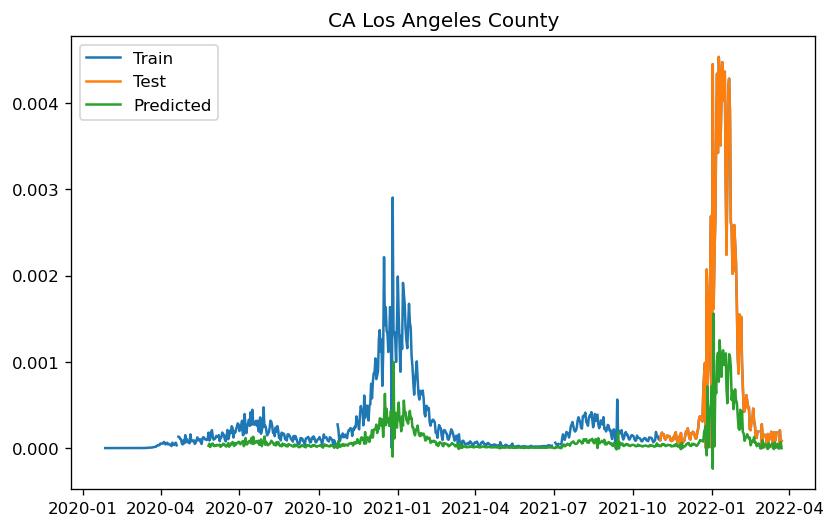

In [23]:
plt.figure(figsize= (8,5))
plt.plot(trainc[target], label= 'Train')
plt.plot(testc[target], label= 'Test')
plt.plot(predictions, label= 'Predicted')
plt.legend(loc= 'upper left')
plt.title(trainc.iloc[1]['state']+ ' ' + trainc.iloc[1]['county'])

In [24]:
from sklearn.metrics import r2_score
r2_score(testc[target].dropna(), testc[testc[target].isna() == False]['prediction'])

0.07949259942986608

In [25]:
target = 'newCasesRatio'
mod = SARIMAX(trainc[target],
            order= (0,1,0),
             freq= 'D',
             exog = trainc[columns])

result = mod.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:          newCasesRatio   No. Observations:                  809
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5107.254
Date:                Sat, 09 Apr 2022   AIC                         -10184.509
Time:                        23:40:29   BIC                         -10114.090
Sample:                    01-05-2020   HQIC                        -10157.470
                         - 03-23-2022                                         
Covariance Type:                  opg                                         
                                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Stay_at_Home

In [26]:
predictions = pd.Series(result.predict(len(testc), exogenous = columns))

trainc.index = trainc.index.astype('datetime64[ns]')
testc.index = testc.index.astype('datetime64[ns]')
predictions.index = predictions.index.astype('datetime64[ns]')

testc['prediction'] = predictions

Text(0.5, 1.0, 'CA Los Angeles County')

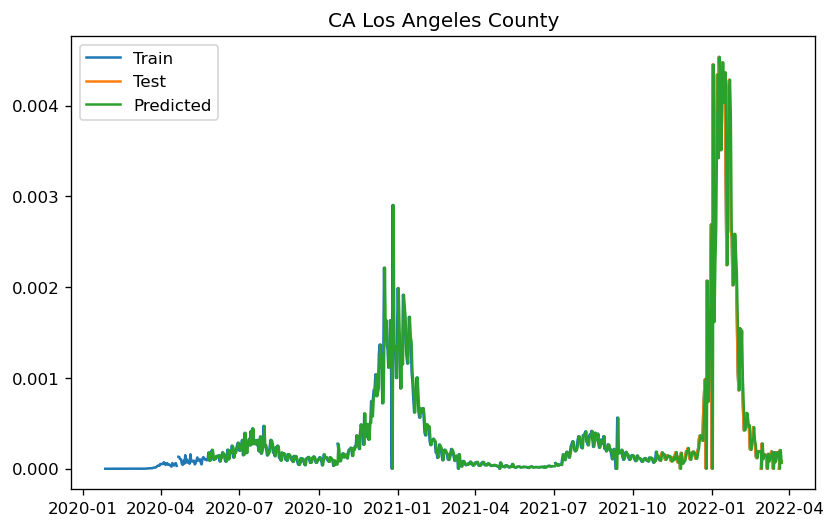

In [28]:
plt.figure(figsize= (8,5))
plt.plot(trainc[target], label= 'Train')
plt.plot(testc[target], label= 'Test')
plt.plot(predictions, label= 'Predicted')
plt.legend(loc= 'upper left')
plt.title(trainc.iloc[1]['state']+ ' ' + trainc.iloc[1]['county'])